In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, r2_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
import torch
from transformers import CLIPProcessor, CLIPModel, CLIPTokenizerFast

In [2]:
def unpickle(file):
    import pickle

    with open(file, "rb") as fo:
        mydict = pickle.load(fo, encoding="bytes")
    return mydict


def create_text_embeddings(text_inputs, batch_size=16):
    text_arr = None
    total_inputs = len(text_inputs)
    for i in range(0, total_inputs, batch_size):
        inputs = text_inputs.tolist()[i : min(i + batch_size, total_inputs)]
        inputs = tokenizer(text=inputs, return_tensors="pt", padding=True, truncation=True)
        text_embeddings = model.get_text_features(**inputs)
        text_embeddings = text_embeddings.cpu().detach().numpy()
        if text_arr is None:
            text_arr = text_embeddings
        else:
            text_arr = np.concatenate((text_arr, text_embeddings), axis=0)
    print("Process of creating text embeddings completed", text_arr.shape, type(text_arr))
    return text_arr


def create_images_embeddings(images_input, batch_size=16):
    images_arr = None
    total_inputs = len(images_input)
    for i in range(0, total_inputs, batch_size):
        image_inputs = images_input[i : min(i + batch_size, total_inputs)]  # (1, 3, 224,224)
        images = processor(
            text=None,
            images=image_inputs.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
            do_rescale=False,
            return_tensors="pt",
        )["pixel_values"].to(device)
        images_embeddings = model.get_image_features(images)
        images_embeddings = images_embeddings.cpu().detach().numpy()
        if images_arr is None:
            images_arr = images_embeddings
        else:
            images_arr = np.concatenate((images_arr, images_embeddings), axis=0)
    print("Process of creating image embeddings completed", images_arr.shape, type(images_arr))
    return images_arr


def train_evaluation_knn_classifier(train_features, train_labels, test_features, test_labels, weights="uniform"):
    knn = KNeighborsClassifier(n_neighbors=3, weights=weights)
    knn.fit(train_features, train_labels)
    predictions = knn.predict(test_features)
    evaluation_reports = (confusion_matrix(test_labels, predictions), classification_report(test_labels, predictions))
    return knn, evaluation_reports


def create_text_inputs(row):
    return f"a photo of a {row['class_label']} which belongs to {row['superclass_label']}"

In [3]:
base_dir = os.getcwd()

train = os.path.join(base_dir, "cifar-100-python", "train")
test = os.path.join(base_dir, "cifar-100-python", "test")
meta = os.path.join(base_dir, "cifar-100-python", "meta")

data = unpickle(train)
test = unpickle(test)
meta = unpickle(meta)
# print('superclasses: ',meta[b'coarse_label_names'])
# print('classes: ',meta[b'fine_label_names'])

class_number = [i for i in range(0, 100)]
class_names = meta[b"fine_label_names"]  # class_labels

superclass_number = [i for i in range(0, 20)]
superclass_names = meta[b"coarse_label_names"]  # superclass_labels

# Mapping the class and superclass numbers to the corresponding labels' name based on the index
class_dict = {class_num: class_name for class_num, class_name in zip(class_number, class_names)}

superclass_dict = {
    superclass_num: superclass_name for superclass_num, superclass_name in zip(superclass_number, superclass_names)
}

### Data Preparation

In [4]:
# Train Set with classes and superclasses labels
df = pd.DataFrame(data=data[b"data"], columns=[i for i in range(1, 3073)])  # pixels
df["class_number"] = data[b"fine_labels"]  # class nums
df["superclass_number"] = data[b"coarse_labels"]
# Return the class and the superclass label names
df["class_label"] = df["class_number"].apply(lambda num: class_dict[num])
df["class_label"] = df["class_label"].apply(lambda value: value.decode("utf-8"))
df["superclass_label"] = df["superclass_number"].apply(lambda num: superclass_dict[num])
df["superclass_label"] = df["superclass_label"].apply(lambda value: value.decode("utf-8"))


# Test Set with classes and superclasses labels
df_test = pd.DataFrame(data=test[b"data"], columns=[i for i in range(1, 3073)])  # pixels
df_test["class_number"] = test[b"fine_labels"]  # class_nums
df_test["superclass_number"] = test[b"coarse_labels"]

# Test set with the class and superclass label names
df_test["class_label"] = df_test["class_number"].apply(lambda num: class_dict[num])
df_test["class_label"] = df_test["class_label"].apply(lambda value: value.decode("utf-8"))
df_test["superclass_label"] = df_test["superclass_number"].apply(lambda num: superclass_dict[num])
df_test["superclass_label"] = df_test["superclass_label"].apply(lambda value: value.decode("utf-8"))

# Choose randomly ten different classes
random.seed(41)
chosen_classes = random.sample(population=class_number, k=10)
assert len(set(chosen_classes)) == 10
df = df[df["class_number"].isin(chosen_classes)]
df_test = df_test[df_test["class_number"].isin(chosen_classes)]

df["index"] = [i for i in range(0, 5000)]
df.set_index("index", inplace=True)
df_test["index"] = [i for i in range(0, 1000)]
df_test.set_index("index", inplace=True)

df.drop(["class_number", "superclass_number"], axis=1, inplace=True)
df_test.drop(["class_number", "superclass_number"], axis=1, inplace=True)

# Initial data for training
X_train = df.iloc[:, :-2].values / 255.0
y_train = df.iloc[:, -2].values

# Initial data for testing
X_test = df_test.iloc[:, :-2].values / 255.0
y_test = df_test.iloc[:, -2].values

In [5]:
# Autoencoder architecture
autoencoder = Sequential(
    [
        Dense(units=1024, activation="relu", input_shape=(3072,)),
        Dense(units=512, activation="relu"),
        Dense(units=256, activation="relu"),
        Dense(units=128, activation="relu"),
        Dense(units=256, activation="relu"),
        Dense(units=512, activation="relu"),
        Dense(units=1024, activation="relu"),
        Dense(units=3072, activation="sigmoid"),
    ]
)

autoencoder.compile(optimizer="adam", loss="mse")

# Using early stopping callback
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=3)

# Fitting the model
autoencoder.fit(
    X_train[:4501],
    X_train[:4501],
    epochs=70,
    batch_size=8,
    validation_data=(X_train[4501:], X_train[4501:]),
    callbacks=[early_stop],
)
autoencoder_loss = pd.DataFrame(autoencoder.history.history)

Epoch 1/70
563/563 [==============================] - 8s 14ms/step - loss: 0.0509 - val_loss: 0.0370
Epoch 2/70
563/563 [==============================] - 8s 14ms/step - loss: 0.0335 - val_loss: 0.0318
Epoch 3/70
563/563 [==============================] - 8s 14ms/step - loss: 0.0321 - val_loss: 0.0317
Epoch 4/70
563/563 [==============================] - 8s 14ms/step - loss: 0.0317 - val_loss: 0.0319
Epoch 5/70
563/563 [==============================] - 8s 14ms/step - loss: 0.0314 - val_loss: 0.0314
Epoch 6/70
563/563 [==============================] - 8s 15ms/step - loss: 0.0300 - val_loss: 0.0287
Epoch 7/70
563/563 [==============================] - 7s 13ms/step - loss: 0.0286 - val_loss: 0.0291
Epoch 8/70
563/563 [==============================] - 9s 16ms/step - loss: 0.0283 - val_loss: 0.0283
Epoch 9/70
563/563 [==============================] - 9s 17ms/step - loss: 0.0274 - val_loss: 0.0267
Epoch 10/70
563/563 [==============================] - 8s 15ms/step - loss: 0.0266 - val_lo

32/32 [==============================] - 0s 5ms/step


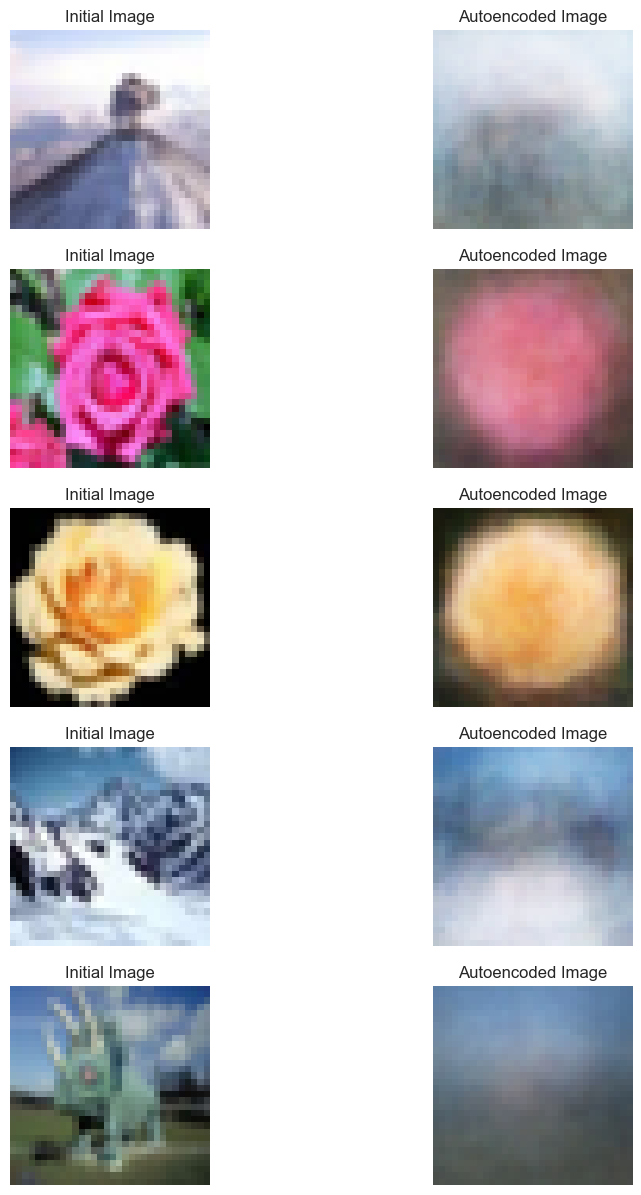

In [6]:
initial_images_test = X_test.reshape(-1, 3, 32, 32).transpose((0, 2, 3, 1))
autoencoded_images_test = autoencoder.predict(X_test)
autoencoded_images_test = autoencoded_images_test.reshape(-1, 3, 32, 32).transpose((0, 2, 3, 1))

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(10, 15))
for i in range(0, 5):
    # Initial images
    axes[i, 0].imshow(initial_images_test[i])
    axes[i, 0].set_title("Initial Image")
    axes[i, 0].axis("off")
    # After autoencoding
    axes[i, 1].imshow(autoencoded_images_test[i])
    axes[i, 1].set_title("Autoencoded Image")
    axes[i, 1].axis("off")

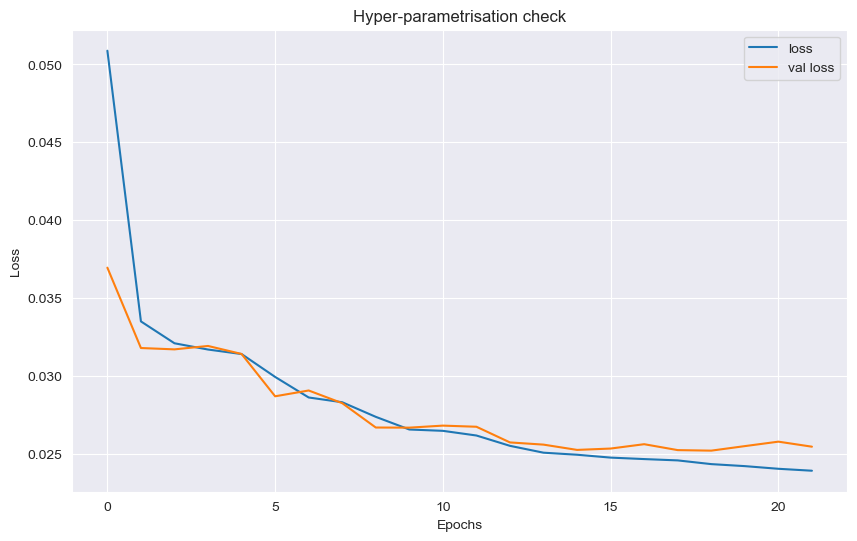

In [7]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=autoencoder_loss, x=autoencoder_loss.index.astype(int), y=autoencoder_loss["loss"], label="loss")
sns.lineplot(
    data=autoencoder_loss, x=autoencoder_loss.index.astype(int), y=autoencoder_loss["val_loss"], label="val loss"
)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Hyper-parametrisation check")
plt.legend()
plt.show()

autoencoded_images_test = autoencoded_images_test.transpose(0, 3, 1, 2).reshape(1000, 3072)

In [8]:
print("Autoencoder's R-squared: ", r2_score(X_test, autoencoded_images_test))

Autoencoder's R-squared:  0.6229839275407202


In [9]:
# Keeping only the encoder part
encoder = Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer(index=4).output)
encoded_features_train = encoder.predict(X_train)
encoded_features_test = encoder.predict(X_test)

32/32 [==============================] - 0s 3ms/step


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_id = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_id).to(device)
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)

images_embeddings_train = create_images_embeddings(images_input=X_train, batch_size=16)
images_embeddings_test = create_images_embeddings(images_input=X_test, batch_size=16)

/opt/anaconda3/envs/deep-learning-env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Process of creating image embeddings completed (5000, 512) <class 'numpy.ndarray'>
Process of creating image embeddings completed (1000, 512) <class 'numpy.ndarray'>


### Image Classification With KNN

In [11]:
knn_raw_images = train_evaluation_knn_classifier(
    train_features=X_train,
    train_labels=y_train,
    test_features=X_test,
    test_labels=y_test,
)
print("Confusion Matrx: \n", knn_raw_images[1][0])
print("Classification Report: \n", knn_raw_images[1][1], "\n" * 3)

Confusion Matrx: 
 [[64 15  1  1  7  1  2  0  7  2]
 [13 49  1  8 14  0  6  1  4  4]
 [ 6 14 20 28 19  0  2  3  3  5]
 [ 2  4 14 47 16  2  3  4  2  6]
 [10 17  2 10 44  0  1  1  4 11]
 [10 16  4  9 19 26  5  1  8  2]
 [ 2  2  0  3  1  0 80  0 12  0]
 [ 2 21  3 11 14  0  5 41  1  2]
 [ 4  6  1  1  8  0  6  1 72  1]
 [ 6 16  5 20 26  0  2  5  4 16]]
Classification Report: 
               precision    recall  f1-score   support

  chimpanzee       0.54      0.64      0.58       100
    dinosaur       0.31      0.49      0.38       100
        girl       0.39      0.20      0.26       100
     hamster       0.34      0.47      0.39       100
     leopard       0.26      0.44      0.33       100
  motorcycle       0.90      0.26      0.40       100
    mountain       0.71      0.80      0.75       100
        rose       0.72      0.41      0.52       100
       shark       0.62      0.72      0.66       100
       tiger       0.33      0.16      0.21       100

    accuracy                 

In [12]:
knn_encoded_images = train_evaluation_knn_classifier(
    train_features=encoded_features_train, train_labels=y_train, test_features=encoded_features_test, test_labels=y_test
)
print("Classification Report: \n", knn_encoded_images[1][1], "\n" * 3)
print("Confusion Matrx: \n", knn_encoded_images[1][0])

Classification Report: 
               precision    recall  f1-score   support

  chimpanzee       0.39      0.72      0.51       100
    dinosaur       0.30      0.46      0.36       100
        girl       0.28      0.33      0.30       100
     hamster       0.43      0.37      0.40       100
     leopard       0.30      0.32      0.31       100
  motorcycle       0.42      0.36      0.39       100
    mountain       0.70      0.62      0.66       100
        rose       0.73      0.41      0.53       100
       shark       0.73      0.48      0.58       100
       tiger       0.35      0.19      0.25       100

    accuracy                           0.43      1000
   macro avg       0.46      0.43      0.43      1000
weighted avg       0.46      0.43      0.43      1000
 



Confusion Matrx: 
 [[72  7  5  1  6  8  1  0  0  0]
 [16 46  6  7  7  7  4  2  0  5]
 [12 17 33 10  8  3  1  4  1 11]
 [ 6  9 20 37 16  1  3  4  0  4]
 [15 19 11  6 32  6  1  0  1  9]
 [26  8  8  4 10 36  2  1  4

In [13]:
knn_image_embeddings = train_evaluation_knn_classifier(
    train_features=images_embeddings_train,
    train_labels=y_train,
    test_features=images_embeddings_test,
    test_labels=y_test,
)
print("Confusion Matrx: \n", knn_image_embeddings[1][0])
print("Classification Report: \n", knn_image_embeddings[1][1], "\n" * 3)

Confusion Matrx: 
 [[98  1  0  1  0  0  0  0  0  0]
 [ 2 82  0  1 10  0  0  0  0  5]
 [ 4  0 96  0  0  0  0  0  0  0]
 [ 3  1  0 92  2  0  0  1  0  1]
 [ 1  5  0  3 78  0  0  0  0 13]
 [ 0  2  0  0  0 97  0  0  1  0]
 [ 1  0  0  0  0  0 99  0  0  0]
 [ 0  1  0  0  1  0  0 98  0  0]
 [ 0  1  0  1  1  0  0  1 94  2]
 [ 3  3  0  3 18  0  0  0  0 73]]
Classification Report: 
               precision    recall  f1-score   support

  chimpanzee       0.88      0.98      0.92       100
    dinosaur       0.85      0.82      0.84       100
        girl       1.00      0.96      0.98       100
     hamster       0.91      0.92      0.92       100
     leopard       0.71      0.78      0.74       100
  motorcycle       1.00      0.97      0.98       100
    mountain       1.00      0.99      0.99       100
        rose       0.98      0.98      0.98       100
       shark       0.99      0.94      0.96       100
       tiger       0.78      0.73      0.75       100

    accuracy                 

### CLIP EMBDDING ZERO-SHOT

In [14]:
df["text_input"] = df.apply(create_text_inputs, axis=1)
df_test["text_input"] = df_test.apply(create_text_inputs, axis=1)
clip_labels = df["text_input"].unique()
# Create text_embeddings
label_embeddings = create_text_embeddings(text_inputs=clip_labels, batch_size=10)
label_embeddings = label_embeddings / np.linalg.norm(label_embeddings, axis=1, keepdims=True)
# Normalize image embeddings
images_embeddings_train_normalized = images_embeddings_train / np.linalg.norm(
    images_embeddings_train, axis=1, keepdims=True
)
image_embeddings_test_normalized = images_embeddings_test / np.linalg.norm(
    images_embeddings_test, axis=1, keepdims=True
)
image_embeddings = np.concatenate((images_embeddings_train_normalized, image_embeddings_test_normalized), axis=0)
score = np.dot(label_embeddings, image_embeddings.T)
indices_of_closest_distances = np.argmax(score, axis=0)
predictions = []
ground_truth_labels = pd.concat((df, df_test), axis=0)["text_input"]
for i in indices_of_closest_distances:
    predictions.append(clip_labels[i])
predictions = np.array(predictions)
print(confusion_matrix(ground_truth_labels, predictions), "\n" * 3)
print(classification_report(ground_truth_labels, predictions), "\n" * 3)
print(accuracy_score(ground_truth_labels, predictions), "\n" * 3)

Process of creating text embeddings completed (10, 512) <class 'numpy.ndarray'>
[[588   0   7   2   0   2   1   0   0   0]
 [ 93 460   1   5   4   5  13   0   4  15]
 [  9   1 570  17   0   2   1   0   0   0]
 [  5   3   2 583   0   0   1   0   0   6]
 [ 74  21   5  23 284   3  14   0   1 175]
 [  1   0   0   0   0 598   1   0   0   0]
 [  0   0   0   0   0   0 600   0   0   0]
 [  3   0   2   3   1   3   4 584   0   0]
 [ 10   3   6   9   0   8  12   0 550   2]
 [ 42   5   7  15   5   2  20   0   0 504]] 



                                                                         precision    recall  f1-score   support

a photo of a chimpanzee which belongs to large_omnivores_and_herbivores       0.71      0.98      0.83       600
                        a photo of a dinosaur which belongs to reptiles       0.93      0.77      0.84       600
                              a photo of a girl which belongs to people       0.95      0.95      0.95       600
                    a photo of a